# 人脸识别
<img src="FaceNet.png" style="width:600px;height:600px;">


## 1 手动搭建Inception模型

In [1]:
import tensorflow as tf
from keras.layers import Input,ZeroPadding2D,BatchNormalization,Activation,MaxPooling2D,Conv2D,AveragePooling2D,Flatten,Dense

from keras.layers import concatenate
from keras.layers.core import Lambda
from keras.models import Model
from keras import backend as K
K.set_image_data_format('channels_first')


from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import os
import numpy as np
from numpy import genfromtxt

Using TensorFlow backend.


In [2]:
def inception_block_1a(X):
    
    X_3X3=Conv2D(96,(1,1),data_format='channels_first',name='inception_3a_3x3_conv1')(X)
    X_3X3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_3x3_bn1')(X_3X3)
    X_3X3=Activation('relu')(X_3X3)
    X_3X3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3X3)
    X_3X3=Conv2D(128,(3,3),data_format='channels_first',name='inception_3a_3x3_conv2')(X_3X3)
    X_3X3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_3x3_bn2')(X_3X3)
    X_3X3=Activation('relu')(X_3X3)
    
    
    X_5X5=Conv2D(16,(1,1),data_format='channels_first',name='inception_3a_5x5_conv1')(X)
    X_5X5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_5x5_bn1')(X_5X5)
    X_5X5=Activation('relu')(X_5X5)
    X_5X5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5X5)
    X_5X5=Conv2D(32,(5,5),data_format='channels_first',name='inception_3a_5x5_conv2')(X_5X5)
    X_5X5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_5x5_bn2')(X_5X5)
    X_5X5=Activation('relu')(X_5X5)
    
    X_pool=MaxPooling2D(pool_size=3,strides=2,data_format='channels_first')(X)
    X_pool=Conv2D(32,(1,1),data_format='channels_first',name='inception_3a_pool_conv')(X_pool)
    X_pool=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_pool_bn')(X_pool)    
    X_pool=Activation('relu')(X_pool)    
    X_pool=ZeroPadding2D(padding=((3,4),(3,4)),data_format='channels_first')(X_pool)    
    
    
    X_1X1=Conv2D(64,(1,1),data_format='channels_first',name='inception_3a_1x1_conv')(X)
    X_1X1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_1x1_bn')(X_1X1)
    X_1X1=Activation('relu')(X_1X1)

    
    inception=concatenate([X_3X3,X_5X5,X_pool,X_1X1],axis=1)
    return inception
    
def inception_block_1b(X):
    
    X_3X3=Conv2D(96,(1,1),data_format='channels_first',name='inception_3b_3x3_conv1')(X)
    X_3X3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_3x3_bn1')(X_3X3)
    X_3X3=Activation('relu')(X_3X3)
    X_3X3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3X3)
    X_3X3=Conv2D(128,(3,3),data_format='channels_first',name='inception_3b_3x3_conv2')(X_3X3)
    X_3X3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_3x3_bn2')(X_3X3)
    X_3X3=Activation('relu')(X_3X3)
    
    
    X_5X5=Conv2D(32,(1,1),data_format='channels_first',name='inception_3b_5x5_conv1')(X)
    X_5X5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_5x5_bn1')(X_5X5)
    X_5X5=Activation('relu')(X_5X5)
    X_5X5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5X5)
    X_5X5=Conv2D(64,(5,5),data_format='channels_first',name='inception_3b_5x5_conv2')(X_5X5)
    X_5X5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_5x5_bn2')(X_5X5)
    X_5X5=Activation('relu')(X_5X5)
    
    X_pool=MaxPooling2D(pool_size=3,strides=3,data_format='channels_first')(X)
    X_pool=Conv2D(64,(1,1),data_format='channels_first',name='inception_3b_pool_conv')(X_pool)
    X_pool=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_pool_bn')(X_pool)    
    X_pool=Activation('relu')(X_pool)    
    X_pool=ZeroPadding2D(padding=(4,4),data_format='channels_first')(X_pool)    
    
    
    X_1X1=Conv2D(64,(1,1),data_format='channels_first',name='inception_3b_1x1_conv')(X)
    X_1X1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_1x1_bn')(X_1X1)
    X_1X1=Activation('relu')(X_1X1)

    
    inception=concatenate([X_3X3,X_5X5,X_pool,X_1X1],axis=1)
    return inception
    

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1,1),
              cv1_strides=(1,1),
              cv2_out=None,
              cv2_filter=(3,3),
              cv2_strides=(1,1),
              padding=None
             ):
    num='' if cv2_out==None else '1'
    tensor=Conv2D(cv1_out,cv1_filter,strides=cv1_strides,data_format='channels_first',name=layer+'_conv'+num)(x)
    tensor=BatchNormalization(axis=1,epsilon=0.00001,name=layer+'_bn'+num)(tensor)
    tensor=Activation('relu')(tensor)
    if padding==None:
        return tensor
    tensor=ZeroPadding2D(padding=padding,data_format='channels_first')(tensor)
    if cv2_out==None:
        return tensor
    tensor=Conv2D(cv2_out,cv2_filter,strides=cv2_strides,data_format='channels_first',name=layer+'_conv'+'2')(tensor)
    tensor=BatchNormalization(axis=1,epsilon=0.00001,name=layer+'_bn'+'2')(tensor)
    tensor=Activation('relu')(tensor)
    return tensor
    
    
def inception_block_1c(X):
    X_3X3=conv2d_bn(X,layer='inception_3c_3x3',
                    cv1_out=128,
                    cv1_filter=(1,1),
                    cv2_out=256,
                    cv2_filter=(3,3),
                    cv2_strides=(2,2),
                    padding=(1,1)                    
                   )
    X_5X5=conv2d_bn(X,layer='inception_3c_5x5',
                    cv1_out=32,
                    cv1_filter=(1,1),
                    cv2_out=64,
                    cv2_filter=(5,5),
                    cv2_strides=(2,2),
                    padding=(2,2)                    
                   )
    X_pool=MaxPooling2D(pool_size=3,strides=2,data_format='channels_first')(X)
    X_pool=ZeroPadding2D(padding=((0,1),(1,0)),data_format='channels_first')(X_pool)
    inception=concatenate([X_3X3,X_5X5,X_pool],axis=1)
    return inception
    
    
def inception_block_2a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_2b(X):
    #inception4e
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_3a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def inception_block_3b(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception
    
    

#### 【bug】 ` Conv2D can accept only 2 positional arguments`


```
<ipython-input-26-6e191cb8eef0> in conv2d_bn(x, layer, cv1_out, cv1_filter, cv1_strides, cv2_out, cv2_filter, cv2_strides, padding)
     79              ):
     80     num='' if cv2_out==None else '1'
---> 81     tensor=Conv2D(cv1_out,cv1_filter,cv1_strides,data_format='channels_first',name=layer+'_conv'+num)(x)
     82     tensor=BatchNormalization(axis=1,epsilon=0.00001,name=layer+'_bn'+num)(tensor)
     83     tensor=Activation('relu')(tensor)

~/miniconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py in wrapper(*args, **kwargs)
     40                                     ', but you passed the following '
     41                                     'positional arguments: ' +
---> 42                                     str(list(args[1:])))
     43             for key in value_conversions:
     44                 if key in kwargs:

TypeError: `Conv2D` can accept only 2 positional arguments ('filters', 'kernel_size'), but you passed the following positional arguments: [128, (1, 1), (1, 1)]

```

- 解决方案:添加 `strides=` 代码`   tensor=Conv2D(cv1_out,cv1_filter,strides=cv1_strides,data_format='channels_first',name=layer+'_conv'+num)(x)`


#### 【bug】`The name "inception_3c_3x3_conv1" is used 2 times in the model`


```
('The name "inception_3c_3x3_conv1" is used 2 times in the model. All layer names should be unique. Layer names: ', ['input_17', 'zero_padding2d_165', 'conv1', 'bn1', 'activation_244', 'zero_padding2d_166', 'max_pooling2d_56', 'conv2', 'bn2', 'activation_245', 'zero_padding2d_167', 'conv3', 'bn3', 'activation_246', 'zero_padding2d_168', 'max_pooling2d_57', 'inception_3a_3X3_conv1', 'inception_3a_5X5_conv1', 'inception_3a_3X3_bn1', 'inception_3a_5X5_bn1', 'activation_247', 'activation_249', 'max_pooling2d_58', 'zero_padding2d_169', 'zero_padding2d_170', 'inception_3a_pool_conv', 'inception_3a_3X3_conv2', 'inception_3a_5X5_conv2', 'inception_3a_pool_bn', 'inception_3a_1X1_conv', 'inception_3a_3X3_bn2', 'inception_3a_5X5_bn2', 'activation_251', 'inception_3a_1X1_bn', 'activation_248', 'activation_250', 'zero_padding2d_171', 'activation_252', 'concatenate_41', 'inception_3b_3X3_conv1', 'inception_3b_5X5_conv1', 'inception_3b_3X3_bn1', 'inception_3b_5X5_bn1', 'activation_253', 'activation_255', 'max_pooling2d_59', 'zero_padding2d_172', 'zero_padding2d_173', 'inception_3b_pool_conv', 'inception_3b_3X3_conv2', 'inception_3b_5X5_conv2', 'inception_3b_pool_bn', 'inception_3b_1X1_conv', 'inception_3b_3X3_bn2', 'inception_3b_5X5_bn2', 'activation_257', 'inception_3b_1X1_bn', 'activation_254', 'activation_256', 'zero_padding2d_174', 'activation_258', 'concatenate_42', 'inception_3c_3x3_conv1', 'inception_3c_5x5_conv1', 'inception_3c_3x3_bn1', 'inception_3c_5x5_bn1', 'activation_259', 'activation_261', 'zero_padding2d_175', 'zero_padding2d_176', 'inception_3c_3x3_conv1', 'inception_3c_5x5_conv1', 'inception_3c_3x3_bn1', 'inception_3c_5x5_bn1',
```

#### 【函数命令】计算L2的norm、Lambda 自定义函数
```
l2_normalize

l2_normalize(x, axis=None)
Normalizes a tensor wrt the L2 norm alongside the specified axis.


```



In [3]:
input_shape=(3, 96, 96)

def faceRecoModel(input_shape):
    X_input=Input(shape=input_shape)

    # Zero-padding
    X=ZeroPadding2D((3,3))(X_input)

    # First block
    X=Conv2D(64,(7,7),strides=(2,2),name='conv1')(X)
    X=BatchNormalization(axis=1,name='bn1')(X)
    X=Activation('relu')(X)

    X=ZeroPadding2D((1,1))(X)
    X=MaxPooling2D((3,3),strides=2)(X)

    # Second block
    X=Conv2D(64,(1,1),strides=(1,1),name='conv2')(X)
    X=BatchNormalization(axis=1,epsilon=0.00001,name='bn2')(X)
    X=Activation('relu')(X)

    X=ZeroPadding2D((1,1))(X)

    X=Conv2D(192,(3,3),strides=(1,1),name='conv3')(X)
    X=BatchNormalization(axis=1,epsilon=0.00001,name='bn3')(X)
    X=Activation('relu')(X)

    X=ZeroPadding2D((1,1))(X)
    X=MaxPooling2D((3,3),strides=2)(X)


    # inception_block_1a
    X=inception_block_1a(X)
    X=inception_block_1b(X)
    X=inception_block_1c(X)

    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)

    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)


    X=AveragePooling2D(pool_size=(3,3),strides=(1,1),data_format='channels_first')(X)
    X=Flatten()(X)
    X=Dense(128,name='dense_layer')(X)
    X=Lambda(lambda x:K.l2_normalize(x,axis=1))(X)
    model=Model(inputs=X_input,outputs=X,name='FaceRecoModel')
    return model


In [4]:
FRmodel=faceRecoModel(input_shape=(3,96,96))

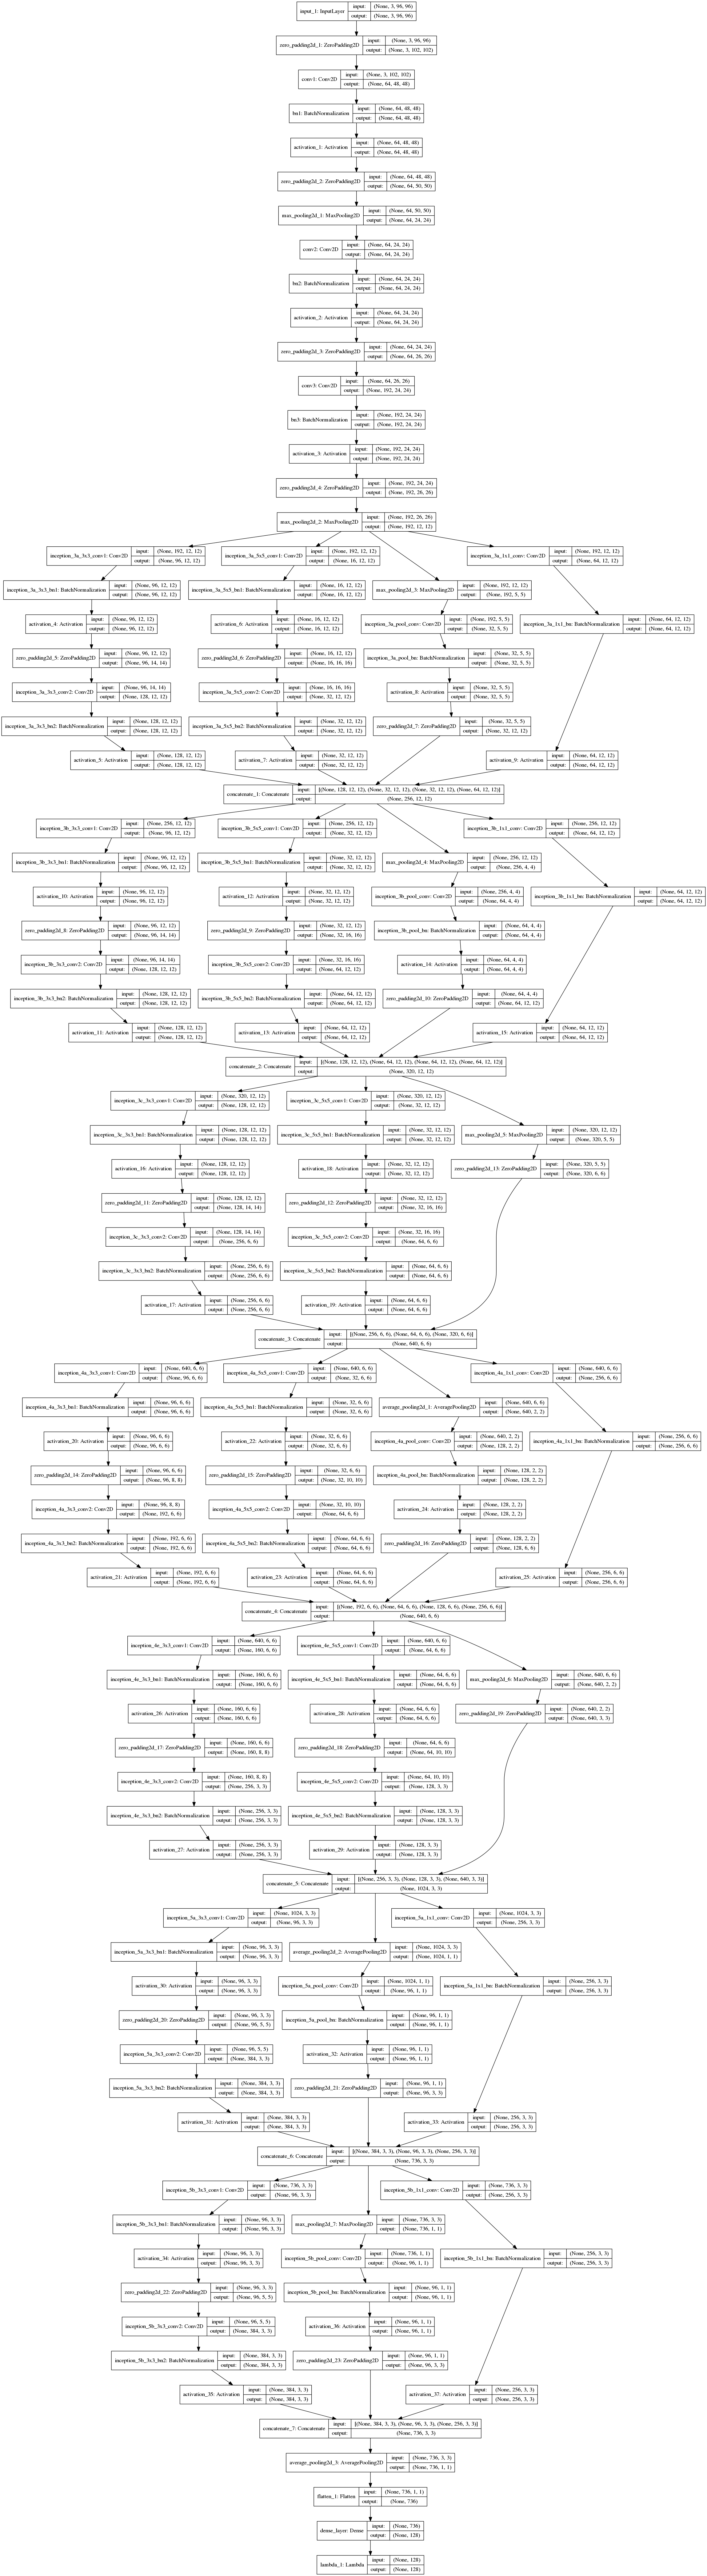

In [5]:
plot_model(FRmodel,to_file="FRmodel_structure.png")
plot_model(FRmodel,to_file="FRmodel_structure_detail.png", show_shapes=True, show_layer_names=True)
# notebook显示
SVG(model_to_dot(FRmodel).create(prog='dot',format='svg'))
# 显示本地图片
Image.open("FRmodel_structure_detail.png")

In [6]:
print("Total params:",FRmodel.count_params())

Total params: 3743280


## FaceNet 和 triplet loss

- 【bug】计算结果不一致： 原因是计算距离pos_dist时，要先分别计算各个sample的距离，最后再统一计算距离；（pos_dist的shape应该为`Tensor("Sum_25:0", shape=(3,), dtype=float32)`）错误代码如下

```
def triplet_loss(y_true,y_pred,alpha=0.2):
    anchor,positive,negative=y_pred
    pos_dist=tf.reduce_sum( tf.square(tf.subtract(anchor,positive)))
    neg_dist=tf.reduce_sum( tf.square(tf.subtract(anchor,negative)))
    basic_loss=pos_dist+alpha-neg_dist
    loss=tf.maximum(basic_loss,0)
    return loss

```


In [7]:
def triplet_loss(y_true,y_pred,alpha=0.2):
#     anchor,positive,negative=y_pred
    anchor,positive,negative=y_pred[0],y_pred[1],y_pred[2]
    pos_dist=tf.reduce_sum( tf.square(tf.subtract(anchor,positive)),axis=-1)
    neg_dist=tf.reduce_sum( tf.square(tf.subtract(anchor,negative)),axis=-1)
    basic_loss=tf.subtract(tf.add(pos_dist,alpha),neg_dist)
    loss=tf.reduce_sum(tf.maximum(basic_loss,0))
    return loss
    
    
    

In [8]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true=(None,None,None)
    y_pred=(tf.random_normal([3,128],mean=6,stddev=0.1,seed=1),
            tf.random_normal([3,128],mean=1,stddev=1,seed=1),
            tf.random_normal([3,128],mean=3,stddev=4,seed=1)
           )
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))


loss = 528.14307


#### 【bug】`'Tensor' object is not iterable.`
```
ipython-input-96-3712ac9f585c> in triplet_loss(y_true, y_pred, alpha)
      1 def triplet_loss(y_true,y_pred,alpha=0.2):
----> 2     anchor,positive,negative=y_pred
      3     pos_dist=tf.reduce_sum( tf.square(tf.subtract(anchor,positive)),axis=-1)
      4     neg_dist=tf.reduce_sum( tf.square(tf.subtract(anchor,negative)),axis=-1)
      5     basic_loss=tf.subtract(tf.add(pos_dist,alpha),neg_dist)

~/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py in __iter__(self)
    539       TypeError: when invoked.
    540     """
--> 541     raise TypeError("'Tensor' object is not iterable.")
    542 
    543   def __bool__(self):

TypeError: 'Tensor' object is not iterable.
```
- 解决方案 `    anchor,positive,negative=y_pred` 改为 `anchor,positive,negative=y_pred[0],y_pred[1],y_pred[2]`

In [9]:
FRmodel.compile(optimizer='adam',loss=triplet_loss,metrics=['accuracy'])

#### 【python函数命令】
```
filter进行过滤获取迭代器

os.listdir获取文件名称

numpy.genfromtxt:Load data from a text file, with missing values handled as specified.


```



In [10]:

WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}
def load_weights():
    # Set weights path
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict


In [11]:
def load_weights_from_FaceNet(FRmodel):
    weights=WEIGHTS
    weights_dict=load_weights()    
    for name in weights:
        if FRmodel.get_layer(name)!=None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])


In [12]:
load_weights_from_FaceNet(FRmodel)

## 3 Face Verification

In [28]:
def img_to_encoding(image_path,model):
    import cv2
    img1=cv2.imread(image_path,1)
    print(image_path)
    img=img1[...,::-1]
    img=np.around(np.transpose(img,(2,0,1))/255.0,decimals=12)
    x_train=np.array([img])
    embedding=model.predict_on_batch(x_train)

    import matplotlib.image as mpimg
    img=mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()
    return embedding



images/danielle.png


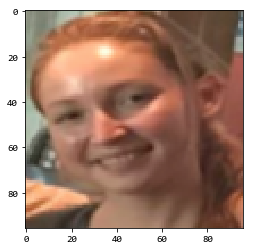

images/younes.jpg


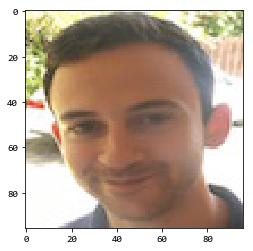

images/tian.jpg


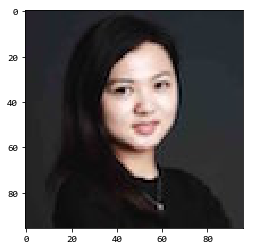

images/andrew.jpg


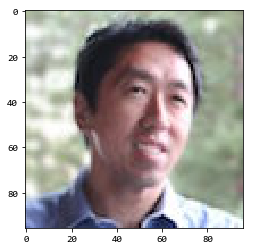

images/kian.jpg


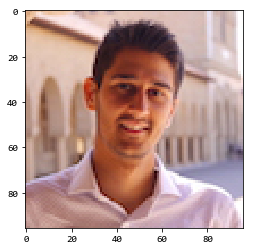

images/dan.jpg


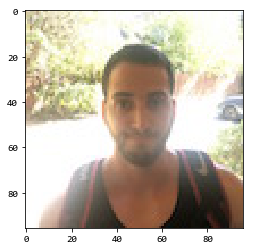

images/sebastiano.jpg


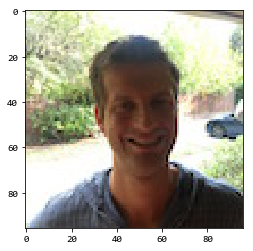

images/bertrand.jpg


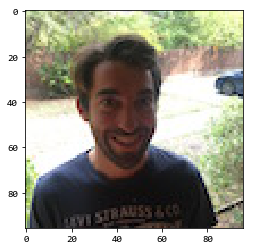

images/kevin.jpg


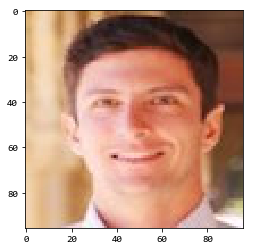

images/felix.jpg


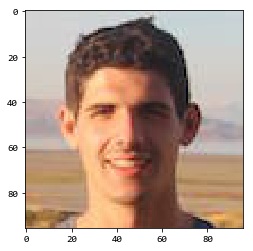

images/benoit.jpg


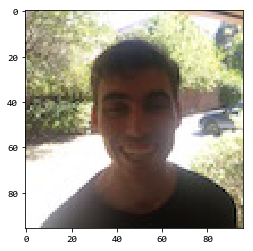

images/arnaud.jpg


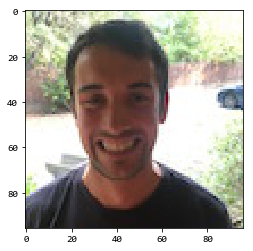

In [29]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

In [30]:
def verify(image_path,identity,database,model):
    encoding=img_to_encoding(image_path,model)
    dist=np.linalg.norm(encoding-database[identity])
    if dist<0.7:
        print("It's" +str(identity)+',welcome')
        door_open=True
    else:
        print("It's not " +str(identity)+',please go away')
        door_open=False
    return dist,door_open

#### 【bug】输出结果不正确，猜测是模型中参数加载时出现错误

images/camera_0.jpg


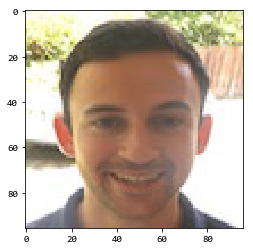

It'syounes,welcome


(0.67100656, True)

In [31]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

images/camera_2.jpg


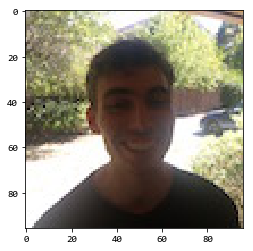

It's not kian,please go away


(0.8580017, False)

In [32]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

## Face Recognition

In [33]:
def who_is_it(image_path,database,model):
    encoding=img_to_encoding(image_path,model)
    min_dist=100
    for name,db_enc in database.items():
        dist=np.linalg.norm(encoding-db_enc)
        if min_dist>dist:
            min_dist=dist
            identity=name
    if min_dist>0.7:
        print("Not in database")
    else:
        print("it is "+str(identity)+', the distance is '+str(min_dist))
    return min_dist,identity
    
    
    
    
    

images/camera_0.jpg


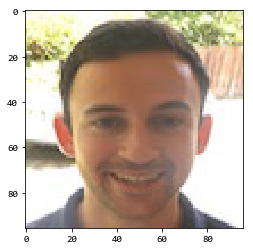

it is younes, the distance is 0.67100656


(0.67100656, 'younes')

In [34]:
who_is_it("images/camera_0.jpg", database, FRmodel)

images/camera_2.jpg


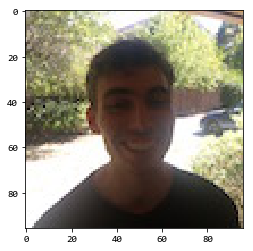

it is benoit, the distance is 0.22077458


(0.22077458, 'benoit')

In [35]:
who_is_it("images/camera_2.jpg", database, FRmodel)

images/camera_3.jpg


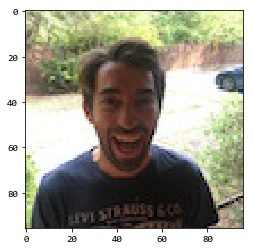

it is bertrand, the distance is 0.36126015


(0.36126015, 'bertrand')

In [36]:
who_is_it("images/camera_3.jpg", database, FRmodel)

images/camera_5.jpg


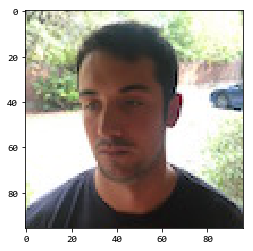

it is dan, the distance is 0.49662542


(0.49662542, 'dan')

In [37]:
who_is_it("images/camera_5.jpg", database, FRmodel)